In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=ead4d5d5f0f5f95a9314489330dba01a62865bad00ef5d3add96119be072844b
  Stored in directory: /root/.cache/pip/wheels/22/a8/60/4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import face_recognition
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
def load_images(path):
    images, labels = [], []
    for person in os.listdir(path):
        person_path = os.path.join(path, person)
        
        # Skip non-directory entries
        if not os.path.isdir(person_path):
            continue

        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = face_recognition.load_image_file(img_path)
            images.append(img)
            labels.append(person)
    return images, labels

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset'
images, labels = load_images(dataset_path)

In [ ]:
# Detect and encode faces
face_encodings = []
labels1=[]
for ind,img in enumerate(images):
      face_locations = face_recognition.face_locations(img)
      if face_locations:
        face_encoding = face_recognition.face_encodings(img, face_locations)[0]
        face_encodings.append(face_encoding)
        labels1.append(labels[ind])


In [ ]:
# Encode labels
le = LabelEncoder()
labels_enc = le.fit_transform(labels1)

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(face_encodings, labels_enc, test_size=0.2, random_state=42)

In [ ]:
# Train a SVM classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Test the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 85.15%
                      precision    recall  f1-score   support

      adam_gilchrist       0.82      0.64      0.72        14
       alastair_cook       0.95      0.86      0.90        22
        allan_donald       0.77      0.88      0.82        26
          brian_lara       0.88      0.79      0.83        28
         chris_gayle       1.00      0.72      0.84        25
      curtly_ambrose       0.74      0.78      0.76        18
          dale_steyn       0.93      0.90      0.92        31
         don_bradman       0.73      0.70      0.72        27
     garfield_sobers       0.97      0.95      0.96        37
       glenn_mcgrath       0.78      0.62      0.69        29
          ian_botham       0.89      0.76      0.82        41
          imran_khan       1.00      0.90      0.95        40
      james_anderson       0.92      0.87      0.89        38
       jaques_kallis       1.00      0.90      0.95        30
           kapil_dev       0.85      0.97      0.90 

In [ ]:
# Save the model and label encoder for future use
import pickle
with open("face_recognition_model.pkl", "wb") as f:
    pickle.dump((clf, le), f)

In [ ]:
import cv2
import os
import face_recognition
import numpy as np
import pickle
from google.colab import files

# Load the saved model and label encoder
with open("face_recognition_model.pkl", "rb") as f:
    clf, le = pickle.load(f)

def recognize_faces(image_path, clf, le):
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)

    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        probabilities = clf.predict_proba([face_encoding])[0]
        max_prob_index = np.argmax(probabilities)
        max_prob = probabilities[max_prob_index]
        label = max_prob_index

        if max_prob > 0.65:  # Adjust this threshold if needed
            name = le.inverse_transform([label])[0]
            parts = name.split("_")
            first_name = parts[0].capitalize()
            if len(parts) > 1:
                last_name = " ".join(word.capitalize() for word in parts[1:])
                name = f"{first_name} {last_name}"
            else:
                name = first_name
        else:
            name = "Unrecognized"

        # Draw a rectangle around the face and add the name label
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return image

Saving unknown.jpg to unknown.jpg


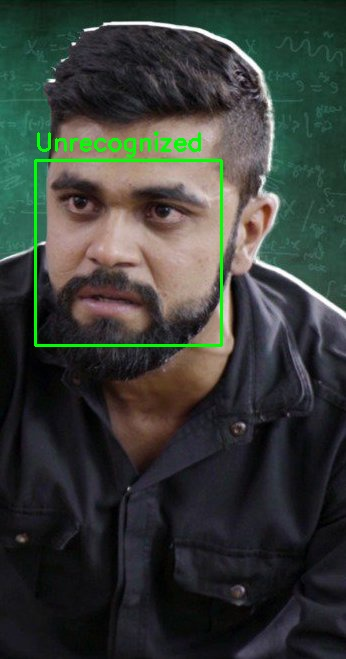

In [ ]:
# Upload an image
uploaded = files.upload()
for file_name in uploaded.keys():
    # Recognize faces in the uploaded image
    image = recognize_faces(file_name, clf, le)
    # Display the image with recognized faces
    from IPython.display import display, Image
    im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display(Image(cv2.imencode('.jpg', im_rgb)[1].tobytes()))
    os.remove(file_name)